In [1]:
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)
import do_mpc
import numpy as np
import matplotlib.pyplot as plt
from data.data_generation import data_generation
from src.model.dynamics_model import dynamics_model
from src.model.mpc_controller import mpc_controller
from src.model.mhe_estimator import mhe_estimator
from src.model.simulator import simulator
from src.util.question_selector import question_selector, benchmark1, benchmark2
from src.util.constants import *

%matplotlib inline

constants.py: S=50, C=1000, and K=5


## Step 1: Generate Questions and Students
<ol>
    <li>Number of Student = S</li>
    <li>Number of Questions = C</li>
    <li>Number of Skills = K</li>
</ol>

In [2]:
'''
# HYPERPARAMETERS
S = 50      # students
C = 10000     # questions
K = 10       # skills
'''

'\n# HYPERPARAMETERS\nS = 50      # students\nC = 10000     # questions\nK = 10       # skills\n'

In [3]:
'''
# APPROACH 1 -- Generate Students and Questions as independent variables
lower, upper = 0, 1
s_mu, s_sigma = 0.25, 0.15  # Mean in 0.25 since assumed low initial skills level
q_mu1, q_sigma1 = 0.25, 0.15
q_mu2, q_sigma2 = 0.75, 0.15
students = stats.truncnorm.rvs((lower-s_mu)/s_sigma,(upper-s_mu)/s_sigma,loc=s_mu,scale=s_sigma,size=(S,K))
questions = stats.truncnorm.rvs((lower-q_mu1)/q_sigma1,(upper-q_mu1)/q_sigma1,loc=q_mu1,scale=q_sigma1,size=(C,K))
questions = np.append(questions, stats.truncnorm.rvs((lower-q_mu2)/q_sigma2,(upper-q_mu2)/q_sigma2,loc=q_mu2,scale=q_sigma2,size=(C,K))).reshape(-1,K)
#questions = np.random.uniform(size=(C,K))
student_norms = np.linalg.norm(students, axis=1)
question_norms = np.linalg.norm(questions, axis=1)
sns.histplot(questions)
'''

'\n# APPROACH 1 -- Generate Students and Questions as independent variables\nlower, upper = 0, 1\ns_mu, s_sigma = 0.25, 0.15  # Mean in 0.25 since assumed low initial skills level\nq_mu1, q_sigma1 = 0.25, 0.15\nq_mu2, q_sigma2 = 0.75, 0.15\nstudents = stats.truncnorm.rvs((lower-s_mu)/s_sigma,(upper-s_mu)/s_sigma,loc=s_mu,scale=s_sigma,size=(S,K))\nquestions = stats.truncnorm.rvs((lower-q_mu1)/q_sigma1,(upper-q_mu1)/q_sigma1,loc=q_mu1,scale=q_sigma1,size=(C,K))\nquestions = np.append(questions, stats.truncnorm.rvs((lower-q_mu2)/q_sigma2,(upper-q_mu2)/q_sigma2,loc=q_mu2,scale=q_sigma2,size=(C,K))).reshape(-1,K)\n#questions = np.random.uniform(size=(C,K))\nstudent_norms = np.linalg.norm(students, axis=1)\nquestion_norms = np.linalg.norm(questions, axis=1)\nsns.histplot(questions)\n'

## For the time being better use approach 1
## Step 2: Model definition

In [4]:
np.random.seed(seed=42)
phi, psi = data_generation()  # phi: students' knowledge, psi: questions
psi[-1] = np.ones(K)
for i in range(2,5):
    psi[-i] = np.ones(K) - 2*i/100
q_tracker = np.zeros((S,2*C), dtype=bool)
model = dynamics_model(S, C, K)
mpc = mpc_controller(model)
sim = simulator(model)
mhe = mhe_estimator(model)
#estimator = do_mpc.estimator.StateFeedback(model)


# Use different initial state for the true system (simulator) and for MHE / MPC
x0_true = phi[7]
x0 = np.zeros(model.n_x)

# Initialize MPC, Sim and MHE
mpc.x0 = x0
sim.x0 = x0_true
mhe.x0 = x0
#estimator.x0 = x0

# Set initial guess for MHE/MPC based on initial state.
mpc.set_initial_guess()
mhe.set_initial_guess()


data_generation() constructed student data with shape (50, 5) and questions data with shape (2000, 5)


C:\Users\ricca\Anaconda3\envs\learning_analytics\lib\site-packages\do_mpc\controller.py:760: UserWarning: rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.
  warnings.warn('rterm was not set and defaults to zero. Changes in the control inputs are not penalized. Can lead to oscillatory behavior.')


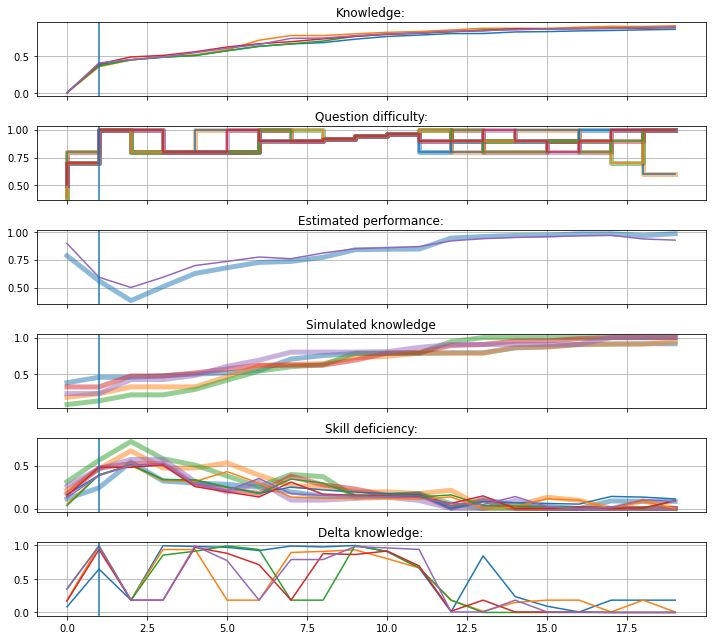

In [7]:
'''Setup graphic'''
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(6,1, sharex=True, figsize=(10, 9))

mpc_plot = do_mpc.graphics.Graphics(mpc.data)
mhe_plot = do_mpc.graphics.Graphics(mhe.data)
sim_plot = do_mpc.graphics.Graphics(sim.data)

ax[0].set_title('Knowledge:')
mhe_plot.add_line('_x', 'x', ax[0])

# ax[0].legend(
#     mpc_plot.result_lines['_x', 'x']+mpc_plot.pred_lines['_x', 'x'],
#     ['Recorded', 'Predicted'], title='Knowledge')

ax[1].set_title('Question difficulty:')
sim_plot.add_line('_u', 'u', ax[1])
mhe_plot.add_line('_u', 'u', ax[1])

ax[2].set_title('Estimated performance:')
sim_plot.add_line('_aux', 'y_meas', ax[2])
mhe_plot.add_line('_aux', 'y_meas', ax[2])

ax[3].set_title('Simulated knowledge')
sim_plot.add_line('_x', 'x', ax[3])

ax[4].set_title('Skill deficiency:')
sim_plot.add_line('_aux', 'alpha', ax[4])
mhe_plot.add_line('_aux', 'alpha', ax[4])

ax[5].set_title('Delta knowledge:')
sim_plot.add_line('_aux', 'delta_x', ax[5])
#mhe_plot.add_line('_z', 'z', ax[5])

for mhe_line_i, sim_line_i in zip(mhe_plot.result_lines.full, sim_plot.result_lines.full):
    mhe_line_i.set_color(sim_line_i.get_color())
    sim_line_i.set_alpha(0.5)
    sim_line_i.set_linewidth(5)

# ax[0].set_ylabel('disc \n angle [rad]')
# ax[1].set_ylabel('disc \n angle [rad]')
# ax[2].set_ylabel('motor \n angle [rad]')
# ax[3].set_ylabel('angle \n velocity [rad/2]')
# ax[4].set_ylabel('mass inertia')
# ax[3].set_xlabel('time [s]')

for ax_i in ax:
    ax_i.axvline(1.0)
    ax_i.grid(True)

fig.tight_layout()
plt.ion()

In [6]:
"""
Run MPC main loop:
"""
from casadi import *

q_previous = x0_true
for k in range(20):
    u0_tilde = mpc.make_step(x0)
    u0, q_tracker = question_selector(u0_tilde, psi, 0, q_tracker)
    # Simulate with process and measurement noise
    ## Benchmark 1: Random selection
    #u0 = benchmark1(psi)

    ## Benchmark 2: Monotonically increasing
    #u0 = benchmark2(psi, q_previous)
    q_previous = u0
    # Simulate with process and measurement noise
    #x_prev = sim.sim_x_num['_x']
    #print(x_prev)
    y_next = sim.make_step(u0,
                            v0=0.01 * np.random.randn(model.n_v,1),
                            w0=0.05 * np.random.randn(model.n_w, 1)
                                )
    x0 = mhe.make_step(y_next)

    #if show_animation:
mpc_plot.plot_results()
mpc_plot.plot_predictions()
mhe_plot.plot_results()
sim_plot.plot_results()

mpc_plot.reset_axes()
mhe_plot.reset_axes()
sim_plot.reset_axes()
plt.show()
plt.pause(0.01)

input('Press any key to exit.')



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      355
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      280

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Total number of variables............................:       80
                     variables with only lower bounds:        0
         

CasADi -  WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 206 (row 10, col 55).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 226 (row 5, col 55).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 226 (row 5, col 55).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 226 (row 5, col 55).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 226 (row 5, col 55).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 226 (row 5, col 55).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        5
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        5
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

CasADi -  WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 226 (row 5, col 55).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 226 (row 5, col 55).") [.../casadi/core/oracle_function.cpp:265]
CasADi -  WARNING("S:nlp_jac_g failed: NaN detected for output jac_g_x, at nonzero index 226 (row 5, col 55).") [.../casadi/core/oracle_function.cpp:265]


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        5
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        5
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

''

In [84]:
result_path = './src/simulations/benchmark_increasing_difficulty/'
result_filename = 'student_8'
do_mpc.data.save_results([sim, mpc, mhe], result_name=result_filename, result_path=result_path, overwrite=True)

In [ ]:
os.getcwd()